<a href="https://colab.research.google.com/github/YISOEUN/ConvNet-Challenge-Colorization/blob/main/ConvNet_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ConvNet_Colorization/

/content/drive/MyDrive/ConvNet_Colorization


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
 # import 
import os
import zipfile
import tqdm
import cv2
import random


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow

import torch
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data  as data
from torchvision.transforms import Compose, ToTensor, ToPILImage
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
import torchvision.models as models
import torch.nn.functional as F

In [5]:
# 제공된 데이터셋 압축 해제
file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive/Multimedia_dataset.zip')

!cp "{zip_path}" .
!unzip -q "{file_name}"
!rm "{file_name}"

In [4]:
### Hyper parameter ###
EPOCH = 30
LR = 0.001

In [7]:
class ColorHintTransform(object):
  def __init__(self, size=256, mode="training"):
    super(ColorHintTransform, self).__init__()
    self.size = size
    self.mode = mode
    self.transform = transforms.Compose([transforms.ToTensor()])

  def bgr_to_lab(self, img): # rgb 채널 -> Lab 채널
      lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
      l, ab = lab[:, :, 0], lab[:, :, 1:]
      return l, ab
  
  def hint_mask(self, bgr, threshold=[0.95, 0.97, 0.99]):
    h, w, c = bgr.shape
    mask_threshold = random.choice(threshold)
    mask = np.random.random([h, w, 1]) > threshold
    return mask

  def __call__(self, img):
    threshold = [0.95, 0.97, 0.99]
    if (self.mode == "training") | (self.mode == "validation")|(self.mode == "testing"):
      image = cv2.resize(img, (self.size, self.size))
      mask = self.hint_mask(image, threshold)

      hint_image = image * mask
      
      l, ab = self.bgr_to_lab(image)
      l_hint, ab_hint = self.bgr_to_lab(hint_image)

      return self.transform(l), self.transform(ab), self.transform(ab_hint)

    else:
      return NotImplementedError

In [8]:
class ColorHintDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(ColorHintDataset, self).__init__()
 
    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None
 
  def set_mode(self, mode):
    self.mode = mode
    self.transforms = ColorHintTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train_color")
      self.examples = [os.path.join(self.root_path, "train_color", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "val_color")
      self.examples = [os.path.join(self.root_path, "val_color", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "test_color")
      self.examples = [os.path.join(self.root_path, "test_color", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)
 
  def __getitem__(self, idx):
    file_name = self.examples[idx]
    img = cv2.imread(file_name)


    l, ab, hint = self.transforms(img)
    sample = {"l": l,"ab": ab,"hint": hint} # hint = ab_hint
    return sample

In [9]:
def tensor2im(input_image, imtype=np.uint8):
  if isinstance(input_image, torch.Tensor):
      image_tensor = input_image.data
  else:
      return input_image
  image_numpy = image_tensor[0].cpu().float().numpy()
  if image_numpy.shape[0] == 1:
      image_numpy = np.tile(image_numpy, (3, 1, 1))
  image_numpy = np.clip((np.transpose(image_numpy, (1, 2, 0)) ),0, 1) * 255.0
  return image_numpy.astype(imtype)


def image_show(img):
  if isinstance(img, torch.Tensor):
    img = ToPILImage()(img)
  plt.imshow(img)
  plt.show()

trainset length:  4500
valset length:  500
testset length:  3
(658, 930, 3)
658


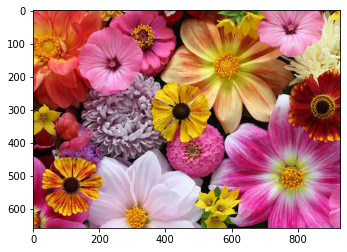

In [10]:
# Dataset Utils
train_root = '/content/drive/MyDrive/ConvNet_Colorization/train_color'
val_root = '/content/drive/MyDrive/ConvNet_Colorization/val_color'
test_root = '/content/drive/MyDrive/ConvNet_Colorization/test_color'

# 파일 이름들
train_examples = os.listdir(train_root)
val_examples = os.listdir(val_root)
test_examples = os.listdir(test_root)

print('trainset length: ', len(train_examples))
print('valset length: ', len(val_examples))
print('testset length: ', len(test_examples))

# image read
img = plt.imread(test_root + '/' + test_examples[0])
print(img.shape) # channel: 3, size: 128 x 128
print(img.shape[0])
#image show
plt.imshow(img)
plt.show()

In [11]:
root = '/content/drive/MyDrive/ConvNet_Colorization'

train_dataset = ColorHintDataset(root,128)
train_dataset.set_mode('training')

val_dataset = ColorHintDataset(root,128)
val_dataset.set_mode('validation')

test_dataset = ColorHintDataset(root, 128)
test_dataset.set_mode('testing')

print('train_dataset lenght: ', len(train_dataset))
print('val_dataset length: ', len(val_dataset))
print('test_dataset length: ', len(test_dataset))

train_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle = False) # 배치 사이즈 변경 필요

train_dataset lenght:  4500
val_dataset length:  500
test_dataset length:  3


In [12]:
### 네트워크 구축
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1, bias = True):
      layers = []
      layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                          kernel_size = kernel_size, stride = stride, padding = padding,
                          bias = bias)]
      layers += [nn.BatchNorm2d(num_features=out_channels)]
      layers += [nn.ReLU()]

      cbr = nn.Sequential(*layers)

      return cbr
   
   # Contracting path
    self.enc1_1 = CBR2d(in_channels = 3, out_channels = 64, kernel_size=3, stride = 1, padding=1, bias = True)
    self.enc1_2 = CBR2d(in_channels = 64, out_channels = 64, kernel_size=3, stride = 1, padding=1, bias = True)

    self.pool1 = nn.MaxPool2d(kernel_size=2)
   
    self.enc2_1 = CBR2d(in_channels = 64, out_channels = 128)
    self.enc2_2 = CBR2d(in_channels = 128, out_channels = 128)

    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.enc3_1 = CBR2d(in_channels = 128, out_channels = 256)
    self.enc3_2 = CBR2d(in_channels = 256, out_channels = 256)

    self.pool3 = nn.MaxPool2d(kernel_size=2)

    self.enc4_1 = CBR2d(in_channels = 256, out_channels = 512)
    self.enc4_2 = CBR2d(in_channels = 512, out_channels = 512)

    self.pool4 = nn.MaxPool2d(kernel_size=2)

    self.enc5_1 = CBR2d(in_channels = 512, out_channels = 1024)

   #Expansive path
    self.dec5_1 = CBR2d(in_channels = 1024, out_channels = 512)

    self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                     kernel_size = 2, stride = 2, padding=0, bias = True)
   
    self.dec4_2 = CBR2d(in_channels = 2*512, out_channels = 512)
    self.dec4_1 = CBR2d(in_channels = 512, out_channels = 256)

    self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                     kernel_size = 2, stride = 2, padding=0, bias = True)

    self.dec3_2 = CBR2d(in_channels = 2*256, out_channels = 256)
    self.dec3_1 = CBR2d(in_channels = 256, out_channels = 128)

    self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                     kernel_size = 2, stride = 2, padding=0, bias = True)

    self.dec2_2 = CBR2d(in_channels = 2*128, out_channels = 128)
    self.dec2_1 = CBR2d(in_channels = 128, out_channels = 64)

    self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                     kernel_size = 2, stride = 2, padding=0, bias = True)

    self.dec1_2 = CBR2d(in_channels = 2*64, out_channels = 64)
    self.dec1_1 = CBR2d(in_channels = 64, out_channels = 64)

    self.fc = nn.Conv2d(in_channels = 64, out_channels=3, kernel_size=1, stride = 1, padding =0 , bias = True)
 
  def forward(self, x):
    enc1_1 = self.enc1_1(x)
    enc1_2 = self.enc1_2(enc1_1)
    pool1 = self.pool1(enc1_2)

    enc2_1 = self.enc2_1(pool1)
    enc2_2 = self.enc2_2(enc2_1)
    pool2 = self.pool2(enc2_2)

    enc3_1 = self.enc3_1(pool2)
    enc3_2 = self.enc3_2(enc3_1)
    pool3 = self.pool3(enc3_2)

    enc4_1 = self.enc4_1(pool3)
    enc4_2 = self.enc4_2(enc4_1)
    pool4 = self.pool4(enc4_2)

    enc5_1 = self.enc5_1(pool4)

    dec5_1 = self.dec5_1(enc5_1)

    unpool4 = self.unpool4(dec5_1)
    cat4 = torch.cat((unpool4, enc4_2), dim = 1)
    dec4_2 = self.dec4_2(cat4)
    dec4_1 = self.dec4_1(dec4_2)

    unpool3 = self.unpool3(dec4_1)
    cat3 = torch.cat((unpool3, enc3_2), dim = 1)
    dec3_2 = self.dec3_2(cat3)
    dec3_1 = self.dec3_1(dec3_2)

    unpool2 = self.unpool2(dec3_1)
    cat2 = torch.cat((unpool2, enc2_2), dim = 1)
    dec2_2 = self.dec2_2(cat2)
    dec2_1 = self.dec2_1(dec2_2)

    unpool1 = self.unpool1(dec2_1)
    cat1 = torch.cat((unpool1, enc1_2), dim = 1)
    dec1_2 = self.dec1_2(cat1)
    dec1_1 = self.dec1_1(dec1_2)  

    x = self.fc(dec1_1)

    return x

In [13]:
print('train dataset length:' , len(train_dataloader)) 
print('val dataset length: ', len(val_dataloader))
print('test dataset length: ', len(test_dataloader))

net = UNet().cuda()

import torch.optim as optim
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

# 훈련 결과 저장
save_path = '/content/drive/MyDrive/colorization-master/ColorizationNetwork/'
os.makedirs(save_path, exist_ok= True)
output_path = os.path.join(save_path, 'validation_model.tar')

train dataset length: 1125
val dataset length:  125
test dataset length:  3


In [14]:
def train_model(net, train_dataloader):
  score_dict = {}
  iteration = 0
  total_loss = 0

  for i, data in enumerate(tqdm.auto.tqdm(train_dataloader)):
    l_imgs = data["l"]
    ab_imgs = data["ab"]
    hint_imgs = data["hint"]

    gt_image = torch.cat((l_imgs,ab_imgs), dim=1)
    hint_image = torch.cat((l_imgs, hint_imgs), dim=1)

    gt_image = gt_image.float().cuda()
    hint_image = hint_image.float().cuda()
    
    optimizer.zero_grad()
    output = net(hint_image).squeeze(1)

    loss = criterion(output, gt_image)
    loss.backward()

    optimizer.step()
    total_loss += loss.detach()
    iteration += 1

  total_loss /= iteration
  return total_loss


In [15]:
def val_model(net, val_dataloader):
  total_loss = 0
  iteration = 0
  net.eval()
  i=0
  for i, data in enumerate(tqdm.auto.tqdm(val_dataloader)):
    l_imgs = data["l"]
    ab_imgs = data["ab"]
    hint_imgs = data["hint"]

    gt_image = torch.cat((l_imgs,ab_imgs), dim=1)
    hint_image = torch.cat((l_imgs, hint_imgs), dim=1)

    gt_image = gt_image.float().cuda()
    hint_image = hint_image.float().cuda()
   
    output = net(hint_image).squeeze(1)

    loss = criterion(output, gt_image)

    total_loss += loss.detach()
    iteration += 1

  total_loss /= iteration
  return total_loss
  

In [16]:
best_loss = 100
train_info = []
val_info = []
for epoch in range(EPOCH):
  t_loss = train_model(net, train_dataloader)
  print('Epoch: {} train_score: {}'.format(epoch, t_loss))
  train_info.append({'loss': t_loss})

  with torch.no_grad():
    v_loss = val_model(net, val_dataloader)
  print('[VALIDATION] Epoch: {} loss: {}'.format(epoch, v_loss))
  val_info.append({'loss': v_loss})
  
  # 검증 loss가 제일 작은 값 저장
  if best_loss > v_loss:
    best_loss = v_loss
    torch.save({
        'memo': 'Colorization',
        'loss' : v_loss,
        'model_weight':net.state_dict()
    }, output_path)

KeyboardInterrupt: ignored

ValueError: ignored

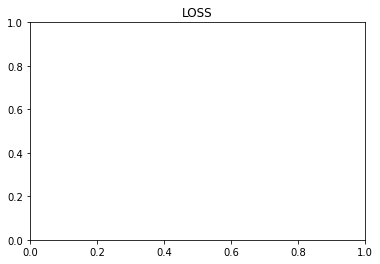

In [17]:
epoch_axis = np.arange(0,EPOCH)
plt.title('LOSS')
plt.plot(epoch_axis, [info['loss'] for info in train_info], epoch_axis, [info['loss'] for info in val_info], 'r-')
plt.legend(['TRAIN', 'VALIDATION'])

plt.show()

In [18]:
model_path = os.path.join(save_path, 'validation_model.tar')
state_dict = torch.load(model_path)

print(state_dict['memo'])
print(state_dict.keys())
print(state_dict['loss'])

net = UNet().cuda()
net.load_state_dict(state_dict['model_weight'], strict = True)

Colorization
dict_keys(['memo', 'loss', 'model_weight'])
tensor(0.0103, device='cuda:0')


<All keys matched successfully>

In [19]:
def test_model(net, test_dataloader):
  net.eval()
  for i, data in enumerate(tqdm.auto.tqdm(test_dataloader)):
    l_imgs = data["l"]
    ab_imgs = data["ab"]
    hint_imgs = data["hint"]

    gt_image = torch.cat((l_imgs,ab_imgs), dim=1)
    hint_image = torch.cat((l_imgs, hint_imgs), dim=1)

    gt_image = gt_image.float().cuda()
    hint_image = hint_image.float().cuda()
   
    output = net(hint_image).squeeze(1)
  

    gt_np = tensor2im(gt_image)
    #hint_np = tensor2im(hint_image)
    output_np = tensor2im(output)

    gt_bgr = cv2.cvtColor(gt_np, cv2.COLOR_LAB2BGR)
    #hint_bgr = cv2.cvtColor(hint_np, cv2.COLOR_LAB2BGR)
    output_bgr = cv2.cvtColor(output_np, cv2.COLOR_LAB2BGR)
  
    cv2_imshow(gt_bgr)
    #cv2_imshow(hint_bgr)
    cv2_imshow(output_bgr)

    # input()



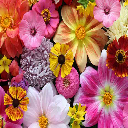

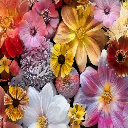

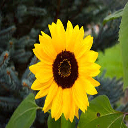

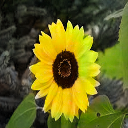

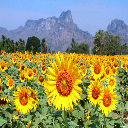

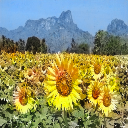

In [21]:
test_model(net, test_dataloader)